### Ciência de Dados Aplicada em Predições de Desempenho para Processamento Paralelo em GPUs

### Benicio Ramos Magalhaes

#### Motivação:

Este trabalho é um estudo de técnicas de predição de desempenho de processamento de computação paralela em GPUs utilizando ciência de dados. O objetivo é modelar o comportamento desses sistemas e estudar diversas técnicas existentes na área de ciência de dados e com isso predizer seu comportamento com relação à métricas não conhecidas. Obtivemos uma base de dados de métricas de desempenho de processamento paralelo de GPUs e a partir dessa base, elaboramos alguns modelos representativos e, por fim, realizamos predições de desempenho com relação às métricas coletadas.

Este projeto é um trabalho final de conclusão de curso apresentado a ICMC - USP São Carlos em Janeiro de 2021.

Para todos os detalhes do estudo realizado, segue o trabalho completo junto a este Jupyter Notebook:

**predicao-de-desempenho-processamento-paralelo-em-GPUs.pdf**

In [68]:
#bibliotecas

import random #randomização
import numpy as np #tratamentos numéricos
import pandas as pd #dataframes
import seaborn as sns #distribuições
import tensorflow as tf #tensorflow
from sklearn import tree #arvore de decisão
from sklearn import metrics #metricas
from sklearn.svm import SVC #técnica SVM
from tensorflow import keras #redes neurais com keras
from imblearn import combine #técnica de SMOTE (combine)
from numpy.random import seed #sementes randomicas
import matplotlib.pyplot as plt #gráficos
from imblearn import over_sampling #técnica de SMOTE (over_sampling)
from imblearn import under_sampling #técnica de SMOTE (under_sampling)
from sklearn.metrics import f1_score #avaliar modelo pela métrica f1_score
from sklearn.decomposition import PCA #técnica PCA
from tensorflow.random import set_seed #sementes tf
from sklearn.metrics import recall_score #avaliar modelo pela métrica recall_score
from sklearn.model_selection import KFold #validacao cruzada
from sklearn.metrics import roc_auc_score #avaliar modelo pela métrica roc_auc_score
from sklearn.naive_bayes import GaussianNB #naive bayes
from sklearn.metrics import accuracy_score #avaliar modelo pela métrica accuracy_score
from sklearn.linear_model import Perceptron #rede neural perceptron
from sklearn.metrics import precision_score #avaliar modelo pela métrica precision_score
from sklearn.metrics import confusion_matrix #matriz de confusão
from sklearn.neural_network import MLPClassifier #multi-layer perceptron
from sklearn.preprocessing import StandardScaler #padronização
from sklearn.metrics import plot_confusion_matrix #análise de matriz de confusão
from sklearn.linear_model import LinearRegression #regressão linear
from sklearn.metrics import classification_report #metricas de validação
from mlxtend.classifier import StackingClassifier #ensemble stack
from sklearn.neighbors import KNeighborsClassifier #k-vizinhos
from sklearn.model_selection import StratifiedKFold #validação cruzada
from sklearn.linear_model import LogisticRegression #regressão logistica que irá juntar os modelos no ensemble

# Descrição dos Dados

In [2]:
#df = pd.read_csv('sgemm_product.csv',sep=',')
df1 = pd.read_csv('sgemm_product.csv',sep=',')
df = df1.sample(frac=0.5) #limitar o tamanho apenas para processamento mais rápido e testar técnicas
print('Número de linhas e colunas:',df.shape)
df.head()

Número de linhas e colunas: (120800, 18)


MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  VWN  STRM  STRN  \
172756  128   64   16      8     16      8     16    2    2    4     0     1   
19971    32   16   16     16      8      8      8    8    1    1     0     0   
45592    32   64   32     32      8      8     16    2    1    2     1     0   
227329  128  128   32      8     32     32     16    8    2    1     0     0   
239256  128  128   32     32      8     32      8    8    4    2     1     0   

        SA  SB  Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)  
172756   0   0     325.74     329.21     329.49     328.71  
19971    1   1      79.09      79.06      79.10      77.22  
45592    0   0      62.10      61.83      62.44      61.40  
227329   0   1     172.85     175.17     175.38     175.13  
239256   0   0     233.98     234.08     234.03     234.42

In [3]:
#descrição estatística
df.describe()

MWG            NWG            KWG          MDIMC  \
count  120800.000000  120800.000000  120800.000000  120800.000000   
mean       80.391921      80.490993      25.505033      13.956225   
std        42.413731      42.435229       7.857187       7.889833   
min        16.000000      16.000000      16.000000       8.000000   
25%        32.000000      32.000000      16.000000       8.000000   
50%        64.000000      64.000000      32.000000       8.000000   
75%       128.000000     128.000000      32.000000      16.000000   
max       128.000000     128.000000      32.000000      32.000000   

               NDIMC          MDIMA          NDIMB            KWI  \
count  120800.000000  120800.000000  120800.000000  120800.000000   
mean       13.936159      17.385364      17.389338       5.004123   
std         7.872200       9.396345       9.394574       3.000010   
min         8.000000       8.000000       8.000000       2.000000   
25%         8.000000       8.000000       8.000000       2.000000   
50%         8.000000      16.000000      16.000000       8.000000   
75%        16.000000      32.000000      32.000000       8.000000   
max        32.000000      32.000000      32.000000       8.000000   

                 VWM            VWN           STRM           STRN  \
count  120800.000000  120800.000000  120800.000000  120800.000000   
mean        2.439123       2.453485       0.501598       0.501002   
std         1.946078       1.959428       0.500000       0.500001   
min         1.000000       1.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         2.000000       2.000000       1.000000       1.000000   
75%         4.000000       4.000000       1.000000       1.000000   
max         8.000000       8.000000       1.000000       1.000000   

                  SA             SB      Run1 (ms)      Run2 (ms)  \
count  120800.000000  120800.000000  120800.000000  120800.000000   
mean        0.500306       0.499743     215.986256     215.924124   
std         0.500002       0.500002     363.889559     363.576989   
min         0.000000       0.000000      13.780000      13.760000   
25%         0.000000       0.000000      40.620000      40.660000   
50%         1.000000       0.000000      69.730000      69.860000   
75%         1.000000       1.000000     228.192500     228.000000   
max         1.000000       1.000000    3339.630000    3375.420000   

           Run3 (ms)      Run4 (ms)  
count  120800.000000  120800.000000  
mean      215.872867     215.869793  
std       363.538239     363.571538  
min        13.730000      13.690000  
25%        40.590000      40.590000  
50%        69.690000      69.755000  
75%       228.005000     228.002500  
max      3397.080000    3361.710000

# Tratamento e transformação dos dados

## Dados duplicados

In [4]:
    #verificando se temos duplicidade dos dados
    df[df.duplicated() == True]

Empty DataFrame
Columns: [MWG, NWG, KWG, MDIMC, NDIMC, MDIMA, NDIMB, KWI, VWM, VWN, STRM, STRN, SA, SB, Run1 (ms), Run2 (ms), Run3 (ms), Run4 (ms)]
Index: []

## Dados faltantes

In [5]:
#verificando se temos dados faltantes
df.isnull().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64

## Outliers

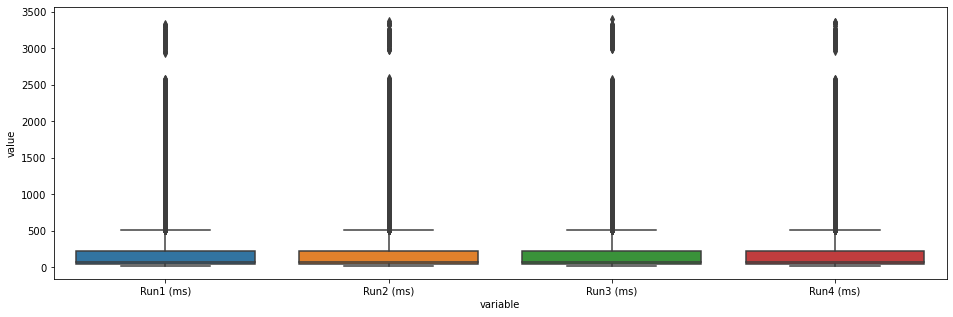

In [6]:
#verificando outliers dos tempos de resposta
plt.figure(figsize=(16,5))
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,-4:]))
plt.show()

In [7]:
#detectando e removendo outliers
def detect_remove_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3-Q1
    mask = ((data > (Q1 - 1.5 * IQR)) & (data < (Q3 + 1.5 * IQR)))
    data_clean = data[mask]
    return data_clean

df_clean = detect_remove_outlier(df)
df_clean.head()

MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  VWN  STRM  STRN  \
172756  128   64   16    8.0   16.0      8     16    2    2    4     0     1   
19971    32   16   16   16.0    8.0      8      8    8    1    1     0     0   
45592    32   64   32    NaN    8.0      8     16    2    1    2     1     0   
227329  128  128   32    8.0    NaN     32     16    8    2    1     0     0   
239256  128  128   32    NaN    8.0     32      8    8    4    2     1     0   

        SA  SB  Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)  
172756   0   0     325.74     329.21     329.49     328.71  
19971    1   1      79.09      79.06      79.10      77.22  
45592    0   0      62.10      61.83      62.44      61.40  
227329   0   1     172.85     175.17     175.38     175.13  
239256   0   0     233.98     234.08     234.03     234.42

In [8]:
#verificando dados faltantes obtidos pela função de outlier
df_clean.isnull().sum().sort_values(ascending=False).head(18)

MDIMC        15753
NDIMC        15641
Run2 (ms)    13396
Run4 (ms)    13392
Run3 (ms)    13388
Run1 (ms)    13248
NDIMB            0
NWG              0
KWG              0
MDIMA            0
VWM              0
KWI              0
VWN              0
STRM             0
STRN             0
SA               0
SB               0
MWG              0
dtype: int64

In [9]:
#dropando as linhas com NaN
df_clean = df_clean.dropna()
df_clean = df_clean.reset_index()
print('Tamanho da base sem outliers:',df_clean.shape)
df_clean.isnull().sum().sort_values(ascending=False).head(18)

Tamanho da base sem outliers: (76569, 19)


Run4 (ms)    0
KWI          0
MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
VWM          0
Run3 (ms)    0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
dtype: int64

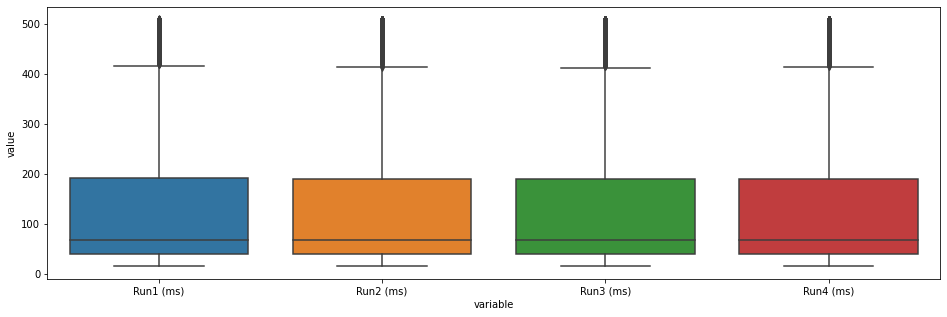

In [10]:
#verificando boxplot dos tempos de resposta após tratamento de outliers
plt.figure(figsize=(16,5))
sns.boxplot(x="variable", y="value", data=pd.melt(df_clean.iloc[:,-4:]))
plt.show()

## Dados correlacionados

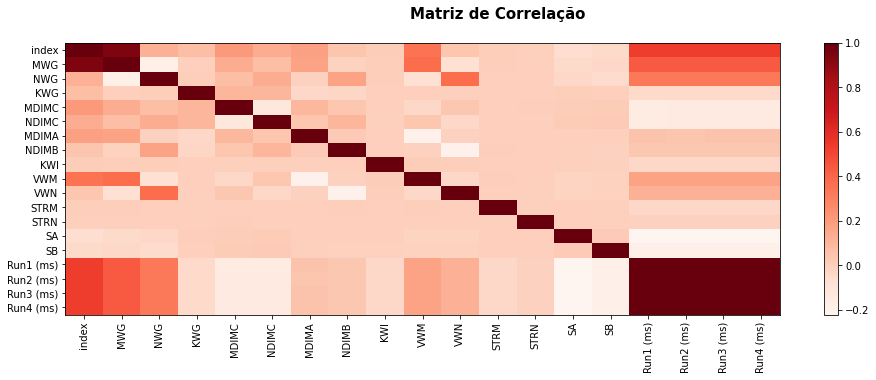

In [12]:
#matriz de correlação
plt.figure(figsize=(16,5))

plt.imshow(df_clean.corr(), cmap='Reds', interpolation='none', aspect='auto')
plt.xticks(range(len(df_clean.corr())), df_clean.corr().columns, rotation='vertical')
plt.yticks(range(len(df_clean.corr())), df_clean.corr().columns)
plt.suptitle('Matriz de Correlação', fontsize=15, fontweight='bold')
plt.grid(False)
plt.colorbar()
plt.show()

## Dados distribuídos e balanceados

In [13]:
#Consolidando os atributos de predição em um único apenas, considerando suas médias
run = df_clean.iloc[:,-4:].mean(axis=1)
df_clean['Run (ms)'] = pd.Series(run)

In [14]:
data = df_clean.copy()
data

index  MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  VWN  STRM  \
0      172756  128   64   16    8.0   16.0      8     16    2    2    4     0   
1       19971   32   16   16   16.0    8.0      8      8    8    1    1     0   
2       11586   16  128   16    8.0    8.0      8     16    8    2    1     0   
3       63572   32  128   32   16.0   16.0     16     32    2    2    4     0   
4      234178  128  128   32   16.0   16.0     16     32    2    8    2     0   
...       ...  ...  ...  ...    ...    ...    ...    ...  ...  ...  ...   ...   
76564  116189   64  128   16    8.0   16.0     16     32    8    4    4     1   
76565  235379  128  128   32   16.0   16.0     32     32    8    2    2     0   
76566  191588  128   64   32   16.0    8.0     16     16    8    1    1     0   
76567   73601   64   32   16    8.0    8.0     32      8    8    1    4     0   
76568  191466  128   64   32   16.0    8.0     16     16    2    2    2     1   

       STRN  SA  SB  Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)  Run (ms)  
0         1   0   0     325.74     329.21     329.49     328.71  328.2875  
1         0   1   1      79.09      79.06      79.10      77.22   78.6175  
2         0   1   0      75.85      75.53      81.16      75.64   77.0450  
3         1   0   0      36.76      36.90      36.69      36.94   36.8225  
4         0   1   0     226.48     227.81     227.61     227.43  227.3325  
...     ...  ..  ..        ...        ...        ...        ...       ...  
76564     1   0   1     184.89     184.34     184.24     184.25  184.4300  
76565     0   1   1     205.02     205.08     205.03     205.02  205.0375  
76566     1   0   0     267.25     266.60     266.45     266.94  266.8100  
76567     0   0   1      71.34      71.32      71.32      71.34   71.3300  
76568     0   1   0     269.55     272.33     269.90     269.83  270.4025  

[76569 rows x 20 columns]

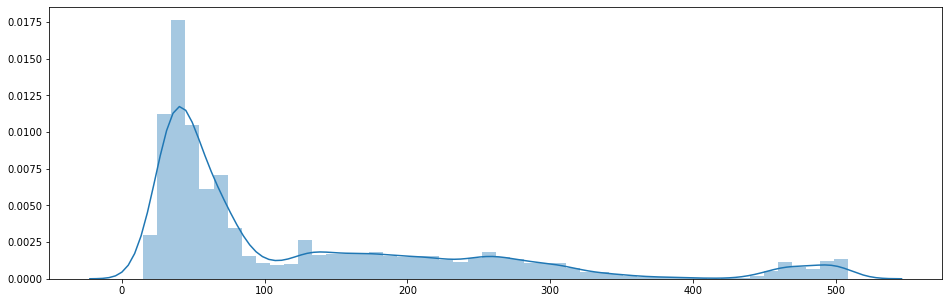

In [15]:
#verificando a distribuição dos dados
plt.figure(figsize=(16,5))
fig = sns.distplot(data.iloc[:,-1:])

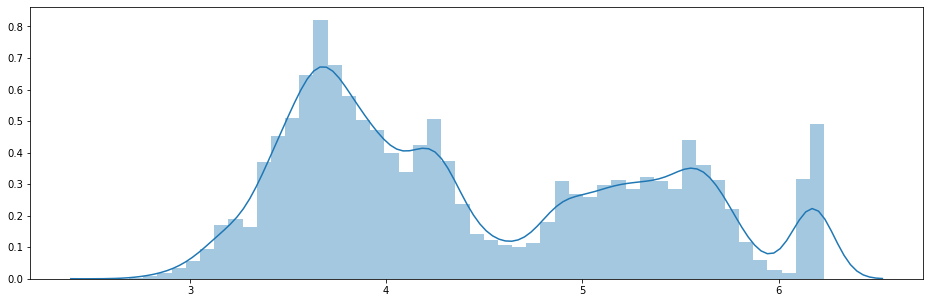

In [16]:
#aplicando log na variável alvo
run_log = np.log(data['Run (ms)'])
data.insert(20,'Run Log (ms)',run_log)

plt.figure(figsize=(16,5))
fig = sns.distplot(data.iloc[:,-1:])

In [17]:
#caso queira apagar a última coluna para dar rollback nos dados
#data.drop(data.iloc[:,-1:],axis = 1, inplace = True)
data

index  MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  ...  STRM  \
0      172756  128   64   16    8.0   16.0      8     16    2    2  ...     0   
1       19971   32   16   16   16.0    8.0      8      8    8    1  ...     0   
2       11586   16  128   16    8.0    8.0      8     16    8    2  ...     0   
3       63572   32  128   32   16.0   16.0     16     32    2    2  ...     0   
4      234178  128  128   32   16.0   16.0     16     32    2    8  ...     0   
...       ...  ...  ...  ...    ...    ...    ...    ...  ...  ...  ...   ...   
76564  116189   64  128   16    8.0   16.0     16     32    8    4  ...     1   
76565  235379  128  128   32   16.0   16.0     32     32    8    2  ...     0   
76566  191588  128   64   32   16.0    8.0     16     16    8    1  ...     0   
76567   73601   64   32   16    8.0    8.0     32      8    8    1  ...     0   
76568  191466  128   64   32   16.0    8.0     16     16    2    2  ...     1   

       STRN  SA  SB  Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)  Run (ms)  \
0         1   0   0     325.74     329.21     329.49     328.71  328.2875   
1         0   1   1      79.09      79.06      79.10      77.22   78.6175   
2         0   1   0      75.85      75.53      81.16      75.64   77.0450   
3         1   0   0      36.76      36.90      36.69      36.94   36.8225   
4         0   1   0     226.48     227.81     227.61     227.43  227.3325   
...     ...  ..  ..        ...        ...        ...        ...       ...   
76564     1   0   1     184.89     184.34     184.24     184.25  184.4300   
76565     0   1   1     205.02     205.08     205.03     205.02  205.0375   
76566     1   0   0     267.25     266.60     266.45     266.94  266.8100   
76567     0   0   1      71.34      71.32      71.32      71.34   71.3300   
76568     0   1   0     269.55     272.33     269.90     269.83  270.4025   

       Run Log (ms)  
0          5.793890  
1          4.364594  
2          4.344390  
3          3.606109  
4          5.426414  
...             ...  
76564      5.217270  
76565      5.323193  
76566      5.586537  
76567      4.267317  
76568      5.599912  

[76569 rows x 21 columns]

In [18]:
#aplicando discretização dos dados no tempo de resposta

#classificação utilizando os dados reais
threshold = [0,20,40,60,80,100,200,300,400,500,600]
run_disc = pd.cut(data['Run (ms)'], bins=threshold)

#inserindo na base
data.insert(21,'Run Discretizado (ms)',run_disc)

#realizando o mapping numbers (transformando categorias em números)
data['Run Discretizado Mapping (ms)'] = data['Run Discretizado (ms)'].astype('category').cat.codes
data['Run Discretizado Mapping (ms)'].unique()

array([7, 3, 1, 6, 2, 5, 8, 4, 9, 0], dtype=int8)

In [19]:
#problema de classificação binária (maior ou menor que a média)

#classificação utilizando os dados reais
avg = data['Run (ms)'].mean()
data.loc[data['Run (ms)'] <= avg, 'Run Bin'] = 0
data.loc[data['Run (ms)'] >  avg, 'Run Bin'] = 1

#obtendo dados
run_bin = data[['Run Bin']].values.astype('int')
data.drop(data.iloc[:,-1:],axis = 1, inplace = True)

#inserindo na base de dados
data.insert(23,'Run Binario',run_bin)

print('Se menor ou igual que ',avg,'então será 0')
print('Se maior que ',avg,'então será 1')

data

Se menor ou igual que  128.63190824615734 então será 0
Se maior que  128.63190824615734 então será 1


index  MWG  NWG  KWG  MDIMC  NDIMC  MDIMA  NDIMB  KWI  VWM  ...  SB  \
0      172756  128   64   16    8.0   16.0      8     16    2    2  ...   0   
1       19971   32   16   16   16.0    8.0      8      8    8    1  ...   1   
2       11586   16  128   16    8.0    8.0      8     16    8    2  ...   0   
3       63572   32  128   32   16.0   16.0     16     32    2    2  ...   0   
4      234178  128  128   32   16.0   16.0     16     32    2    8  ...   0   
...       ...  ...  ...  ...    ...    ...    ...    ...  ...  ...  ...  ..   
76564  116189   64  128   16    8.0   16.0     16     32    8    4  ...   1   
76565  235379  128  128   32   16.0   16.0     32     32    8    2  ...   1   
76566  191588  128   64   32   16.0    8.0     16     16    8    1  ...   0   
76567   73601   64   32   16    8.0    8.0     32      8    8    1  ...   1   
76568  191466  128   64   32   16.0    8.0     16     16    2    2  ...   0   

       Run1 (ms)  Run2 (ms)  Run3 (ms)  Run4 (ms)  Run (ms)  Run Log (ms)  \
0         325.74     329.21     329.49     328.71  328.2875      5.793890   
1          79.09      79.06      79.10      77.22   78.6175      4.364594   
2          75.85      75.53      81.16      75.64   77.0450      4.344390   
3          36.76      36.90      36.69      36.94   36.8225      3.606109   
4         226.48     227.81     227.61     227.43  227.3325      5.426414   
...          ...        ...        ...        ...       ...           ...   
76564     184.89     184.34     184.24     184.25  184.4300      5.217270   
76565     205.02     205.08     205.03     205.02  205.0375      5.323193   
76566     267.25     266.60     266.45     266.94  266.8100      5.586537   
76567      71.34      71.32      71.32      71.34   71.3300      4.267317   
76568     269.55     272.33     269.90     269.83  270.4025      5.599912   

       Run Discretizado (ms)  Run Discretizado Mapping (ms)  Run Binario  
0                 (300, 400]                              7            1  
1                   (60, 80]                              3            0  
2                   (60, 80]                              3            0  
3                   (20, 40]                              1            0  
4                 (200, 300]                              6            1  
...                      ...                            ...          ...  
76564             (100, 200]                              5            1  
76565             (200, 300]                              6            1  
76566             (200, 300]                              6            1  
76567               (60, 80]                              3            0  
76568             (200, 300]                              6            1  

[76569 rows x 24 columns]

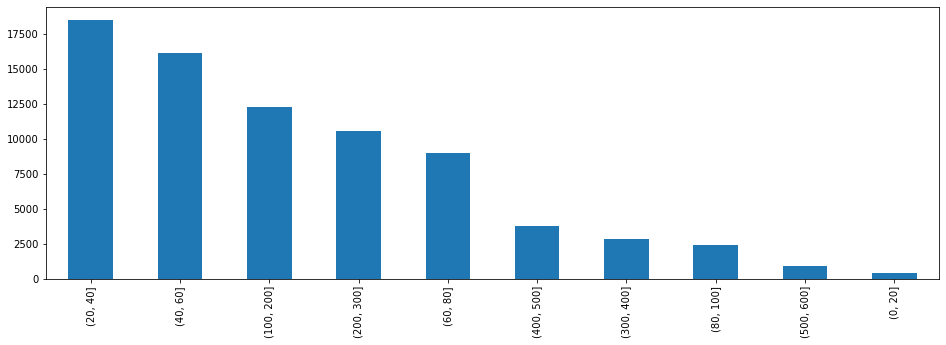

In [20]:
#verificando balanceamento entre as variáveis categóricas (multiclasse)
fig = plt.figure(figsize=(16,5))
fig = data['Run Discretizado (ms)'].value_counts().plot(kind='bar')

Distribuição das classes:
[000,020]: 0.52 %
[020,040]: 24.15 %
[040,060]: 21.00 %
[060,080]: 11.67 %
[000,100]: 3.17 %
[100,200]: 15.99 %
[200,300]: 13.77 %
[300,400]: 3.70  %
[400,500]: 4.86  %
[500,600]: 1.17  %


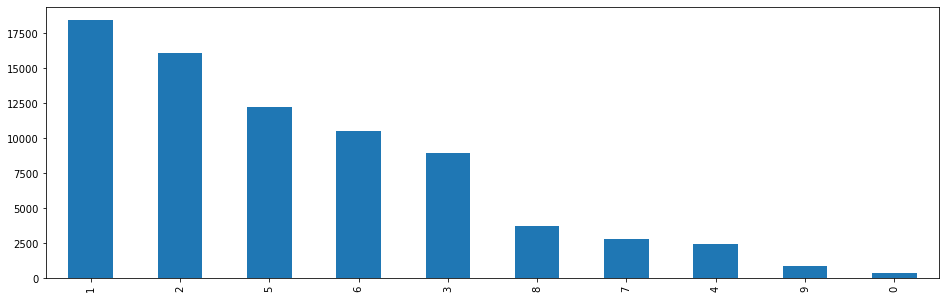

In [21]:
#verificando balanceamento entre as variáveis categóricas mapping (multiclasse)
fig = plt.figure(figsize=(16,5))
fig = data['Run Discretizado Mapping (ms)'].value_counts().plot(kind='bar')

#classificação utilizando os dados reais
mask0 = (data['Run Discretizado Mapping (ms)'] == 0)
mask1 = (data['Run Discretizado Mapping (ms)'] == 1)
mask2 = (data['Run Discretizado Mapping (ms)'] == 2)
mask3 = (data['Run Discretizado Mapping (ms)'] == 3)
mask4 = (data['Run Discretizado Mapping (ms)'] == 4)
mask5 = (data['Run Discretizado Mapping (ms)'] == 5)
mask6 = (data['Run Discretizado Mapping (ms)'] == 6)
mask7 = (data['Run Discretizado Mapping (ms)'] == 7)
mask8 = (data['Run Discretizado Mapping (ms)'] == 8)
mask9 = (data['Run Discretizado Mapping (ms)'] == 9)

print('Distribuição das classes:')
print("[000,020]: %.2f" % (len(data[mask0].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[020,040]: %.2f" % (len(data[mask1].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[040,060]: %.2f" % (len(data[mask2].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[060,080]: %.2f" % (len(data[mask3].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[000,100]: %.2f" % (len(data[mask4].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[100,200]: %.2f" % (len(data[mask5].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[200,300]: %.2f" % (len(data[mask6].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[300,400]: %.2f" % (len(data[mask7].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),' %')
print("[400,500]: %.2f" % (len(data[mask8].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),' %')
print("[500,600]: %.2f" % (len(data[mask9].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),' %')

Distribuição das classes:
 <= Média: 63.68 %
 >  Média: 36.32 %


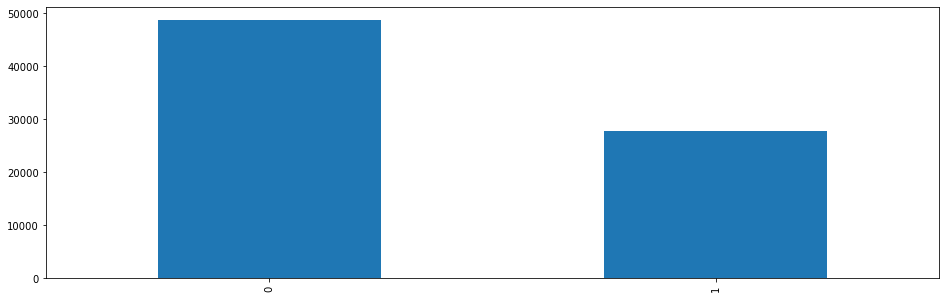

In [22]:
#verificando balanceamento entre as variáveis binárias
fig = plt.figure(figsize=(16,5))
fig = data['Run Binario'].value_counts().plot(kind='bar')

mask0 = (data['Run Binario'] == 0)
mask1 = (data['Run Binario'] == 1)

print('Distribuição das classes:')
print(" <= Média: %.2f" % (len(data[mask0].index.values)/len(data['Run Binario']) * 100),'%')
print(" >  Média: %.2f" % (len(data[mask1].index.values)/len(data['Run Binario']) * 100),'%')

In [23]:
#separando os dados em conjunto de treinamento e testes, na proporção 80-20
perc = 0.8

#salvando y como seria valores reais em logaritimo
x_train_log, y_train_log = data.iloc[0:int(len(data)*perc),1:-9],data['Run Log (ms)'].iloc[0:int(len(data)*perc)]
x_test_log, y_test_log = data.iloc[int(len(data)*perc):int(len(data)),1:-9],data['Run Log (ms)'].iloc[int(len(data)*perc):int(len(data))]

#salvando y como serie classificação multiclasse
x_train_m, y_train_m = data.iloc[0:int(len(data)*perc),1:-9],data['Run Discretizado (ms)'].iloc[0:int(len(data)*perc)]
x_test_m, y_test_m = data.iloc[int(len(data)*perc):int(len(data)),1:-9],data['Run Discretizado (ms)'].iloc[int(len(data)*perc):int(len(data))]

#salvando y como serie classificação multiclasse mapping number
x_train_map, y_train_map = data.iloc[0:int(len(data)*perc),1:-9],data['Run Discretizado Mapping (ms)'].iloc[0:int(len(data)*perc)]
x_test_map, y_test_map = data.iloc[int(len(data)*perc):int(len(data)),1:-9],data['Run Discretizado Mapping (ms)'].iloc[int(len(data)*perc):int(len(data))]

#salvando y como classificação binário
x_train_b, y_train_b = data.iloc[0:int(len(data)*perc),1:-9],data['Run Binario'].iloc[0:int(len(data)*perc)]
x_test_b, y_test_b = data.iloc[int(len(data)*perc):int(len(data)),1:-9],data['Run Binario'].iloc[int(len(data)*perc):int(len(data))]


sc = StandardScaler()
x_train_m = sc.fit_transform(x_train_m)
x_test_m = sc.fit_transform(x_test_m)

x_train_map = sc.fit_transform(x_train_map)
x_test_map = sc.fit_transform(x_test_map)

x_train_b = sc.fit_transform(x_train_b)
x_test_b = sc.fit_transform(x_test_b)

print('Tamanho da amostra de treinamento:',len(x_train_b))
print('Tamanho da amostra de teste:',len(x_test_b))

Tamanho da amostra de treinamento: 61255
Tamanho da amostra de teste: 15314


### OTIMIZANDO A DISTRIBUIÇÃO

Vamos utilizar nos modelos os dados discretizados com mapping para classificação e os dados binários.

Primeiramente vamos tentar melhorar a distribuição dos dados com a técnica de SMOTE.

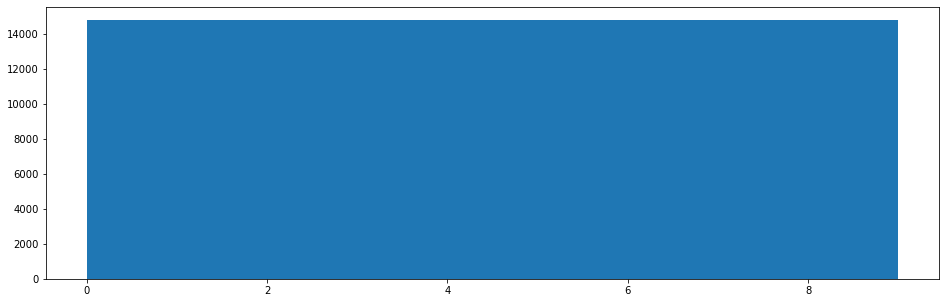

In [24]:
#aplicando técnicas de SMOTE para verificar se conseguimos uma estratégia melhor de balanceamento dos dados para validar os modelos

#Over Sampling
oversamp = over_sampling.SMOTE()
Xo, Yo = oversamp.fit_resample(x_train_map, y_train_map)

plt.figure(figsize=(16,5))
h = plt.hist(Yo)

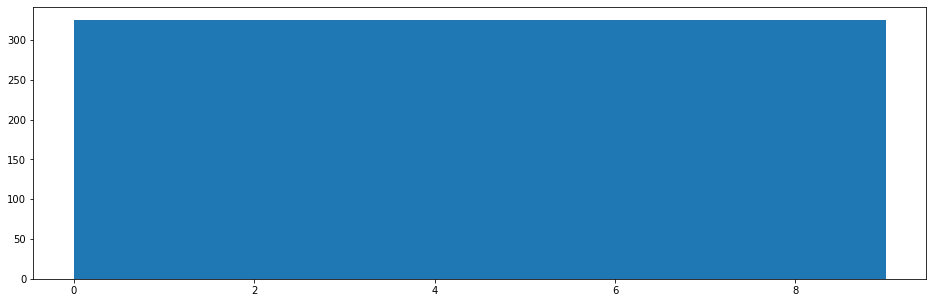

In [25]:
#Under Sampling
undersamp = under_sampling.RandomUnderSampler()
Xu, Yu = undersamp.fit_resample(x_train_map, y_train_map)

plt.figure(figsize=(16,5))
h = plt.hist(Yu)

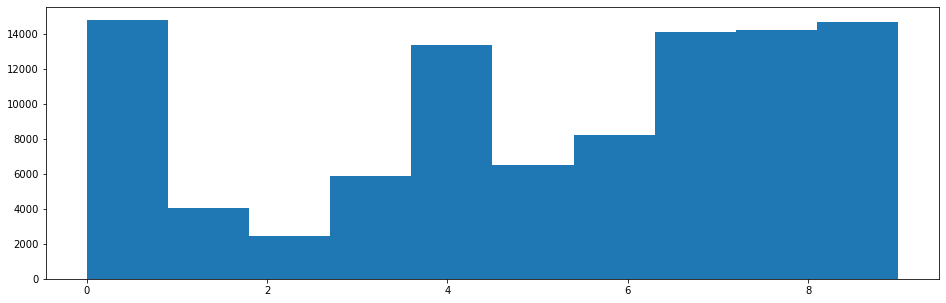

In [26]:
#Over Under Sampling (estratégia mista)
overunder = combine.SMOTEENN(sampling_strategy='all')
Xc, Yc = overunder.fit_resample(x_train_map, y_train_map)

plt.figure(figsize=(16,5))
h = plt.hist(Yc)

In [27]:
#avaliando qual a melhor estratégia de SMOTE aplicando uma modelagem do tipo SVM

#treinando um classificador com o balanceamento original
clf = SVC(gamma='auto')
clf.fit(x_train_map,y_train_map)
ZY_ = clf.predict(x_test_map)

#treinando um classificador com o balanceamento Over Sampling
clf_ov = SVC(gamma='auto')
clf_ov.fit(Xo,Yo)
ZYov_ = clf_ov.predict(x_test_map)

#treinando um classificador com o balanceamento Under Sampling
clf_un = SVC(gamma='auto')
clf_un.fit(Xu,Yu)
ZYun_ = clf_un.predict(x_test_map)

#treinando um classificador com o balanceamento Over Under Sampling
clf_co = SVC(gamma='auto')
clf_co.fit(Xc,Yc)
ZYco_ = clf_co.predict(x_test_map)

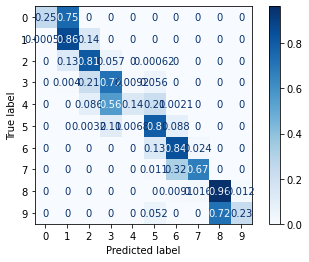

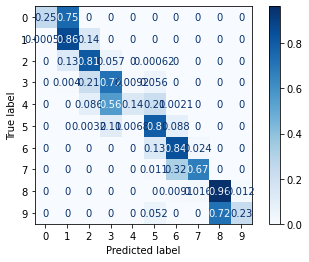

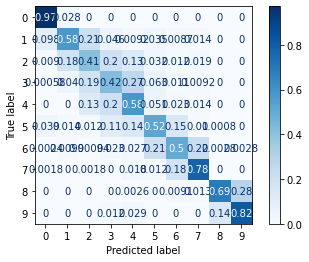

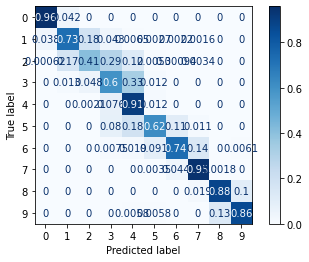

In [28]:
#avaliando a matriz confusão dos modelos com as diferentes estratégias de balanceamento

#matriz de confusão do balanceamento original
disp = plot_confusion_matrix(clf, x_test_map, y_test_map,
                             cmap=plt.cm.Blues,
                             normalize='true')

#matriz de confusão do balanceamento Over Sampling
disp = plot_confusion_matrix(clf, x_test_map, y_test_map,
                             cmap=plt.cm.Blues,
                             normalize='true')

#matriz de confusão do balanceamento Under Sampling
disp = plot_confusion_matrix(clf_un, x_test_map, y_test_map,
                             cmap=plt.cm.Blues,
                             normalize='true')

#matriz de confusão do balanceamento Over Under Sampling
disp = plot_confusion_matrix(clf_co, x_test_map, y_test_map,
                             cmap=plt.cm.Blues,
                             normalize='true')

In [31]:
#avaliando os resultados com as diferentes estratégias de balanceamento
print('+------------------------------------------------------------------+')
print('Resultados com o balanceamento original:')
print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, ZY_))
print('+------------------------------------------------------------------+')
print('Resultados com o balanceamento Over Sampling:')
print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, ZYov_))
print('+------------------------------------------------------------------+')
print('Resultados com o balanceamento Under Sampling:')
print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, ZYun_))
print('+------------------------------------------------------------------+')
print('Resultados com o balanceamento Over Under Sampling:')
print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, ZYco_))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
Resultados com o balanceamento original:
+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.90      0.25      0.39        72
           1       0.87      0.86      0.87      3689
           2       0.74      0.81      0.77      3205
           3       0.63      0.72      0.67      1739
           4       0.68      0.14      0.23       487
           5       0.80      0.80      0.80      2491
           6       0.81      0.84      0.83      2121
           7       0.86      0.67      0.75       566
           8       0.86      0.96      0.91       772
           9       0.81      0.23      0.35       172

    accuracy                           0.79     15314
   macro avg       0.80      0.63      0.66     15314
weighted avg       0.79      0.79      0.78     15314

+-------------------------------------------------------------

As estratégias com os dados originais e com o balanceamento Over Sampling, ficaram praticamente equivalentes. Tivemos um pequeno ganho com relação ao recall, subindo a média um pouco para o over sampling. Mesmo considerando pouco o ganho, vamos utilizar essa estratégia na nossa modelagem.

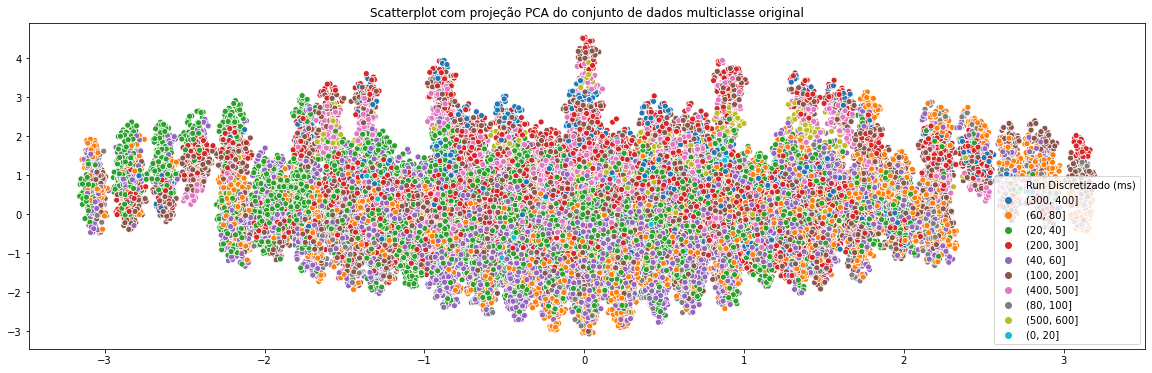

In [33]:
#apresentando os dados graficamente

#aplicando PCA e plotando dados com conjunto original de dados de treino (multiclasse)
pca = PCA(n_components=10, random_state=1)
pca_result = pca.fit_transform(x_train_m)

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],alpha='auto', hue=y_train_m, palette='tab10')
plt.title('Scatterplot com projeção PCA do conjunto de dados multiclasse original')
plt.show()

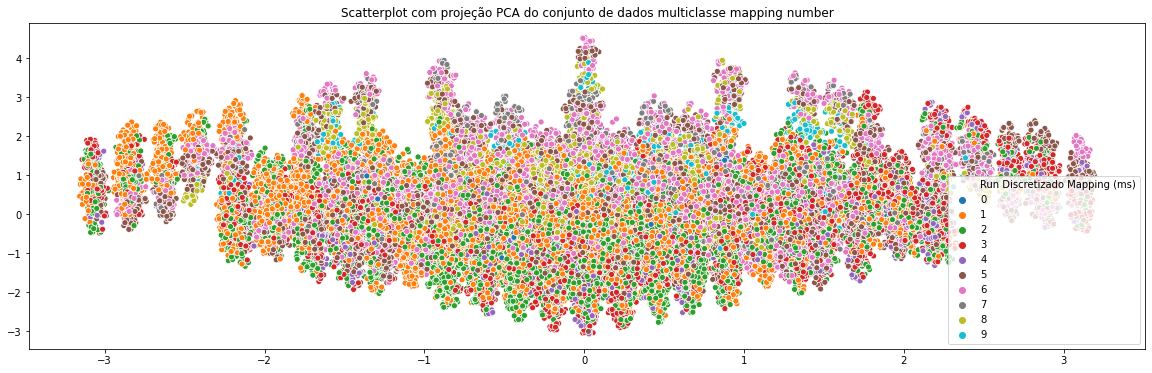

In [35]:
#apresentando os dados graficamente

#aplicando PCA e plotando dados com conjunto original de dados de treino (multiclasse mapping number)
pca = PCA(n_components=10, random_state=1)
pca_result = pca.fit_transform(x_train_map)

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],alpha='auto', hue=y_train_map, palette='tab10')
plt.title('Scatterplot com projeção PCA do conjunto de dados multiclasse mapping number')
plt.show()

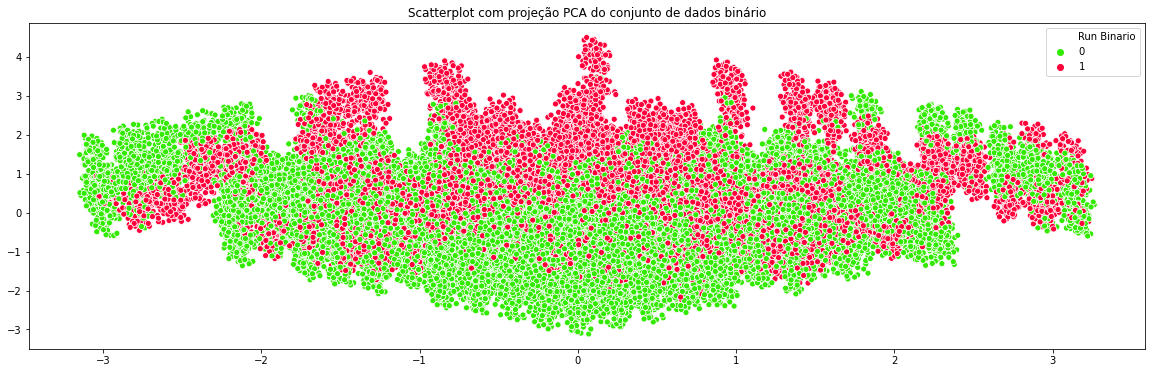

In [38]:
#aplicando PCA e plotando dados com conjunto original de dados de treino (binário)
pca = PCA(n_components=2, random_state=1)
pca_result = pca.fit_transform(x_train_b)

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],alpha='auto', hue=y_train_b, palette='prism')
plt.title('Scatterplot com projeção PCA do conjunto de dados binário')
plt.show()

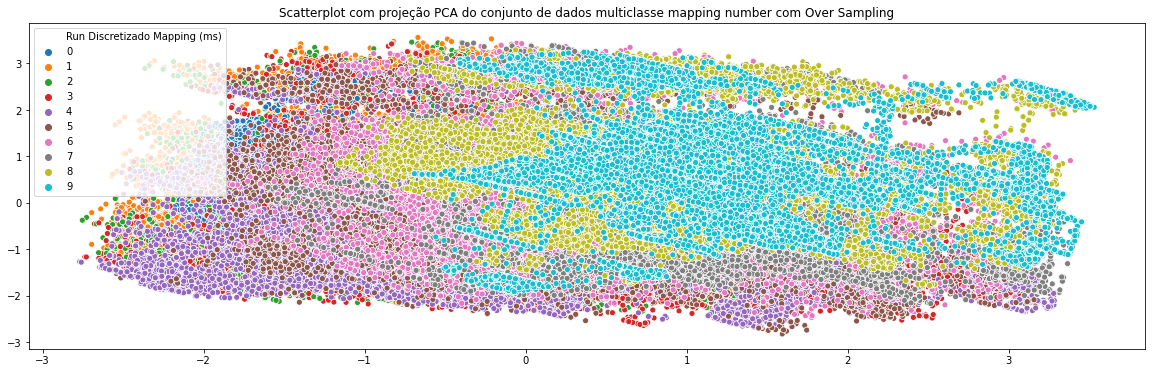

In [37]:
import warnings
warnings.filterwarnings("ignore")

#aplicando PCA e plotando dados com conjunto original de dados de treino (multiclasse mapping number) com Over Sampling
pca = PCA(n_components=10, random_state=1)
pca_result = pca.fit_transform(Xo)

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],alpha='auto', hue=Yo, palette='tab10')
plt.title('Scatterplot com projeção PCA do conjunto de dados multiclasse mapping number com Over Sampling')
plt.show()

## ESTRATÉGIAS DE MODELAGEM 

### K-NN (VIZINHOS MAIS PRÓXIMOS)

Melhor k: 7  AUC: 0.7933297407939466


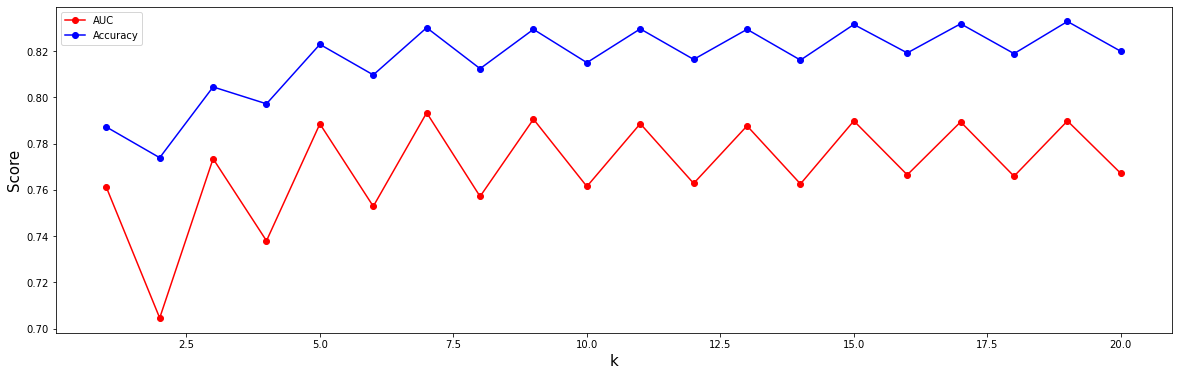

In [40]:
#identificando melhor parâmetro K para aplicar nos modelos

cv_knn = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) #validação cruzada

#fatiando ainda mais os dados, para viabilizar a simulação em várias execuções 
#estamos realizando em cima dos dados binários, pois tivemos muitos problemas/erros no cálculo das métricas
#para um problema de classificação multi-classe.
train_x = x_train_b[:10000] 
train_y = y_train_b[:10000]

mauc_knn = []
macc_knn = []
vk = []

for k in range(1, 21):
    vauc_knn = []
    vacc_knn = []
    for train_index, test_index in cv_knn.split(train_x, train_y):
        x_train, x_test = x_train_b[train_index], x_train_b[test_index]
        y_train, y_test = y_train_b[train_index], y_train_b[test_index]
        model_knn = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
        model_knn.fit(x_train,y_train)
        y_pred_knn = model_knn.predict(x_test) 
        score = accuracy_score(y_pred_knn, y_test)
        vauc_knn.append(roc_auc_score(y_test, y_pred_knn))
        vacc_knn.append(accuracy_score(y_pred_knn, y_test))
    macc_knn.append(np.mean(vacc_knn))
    mauc_knn.append(np.mean(vauc_knn))
    vk.append(k)

#identificando o melhor parâmetro K, dada a acurácia e o AUC
best_k = np.argmax(mauc_knn)+1
print('Melhor k:', best_k, ' AUC:',mauc_knn[best_k-1])
plt.figure(figsize=(20,6))
plt.plot(vk, mauc_knn, '-ro', label= 'AUC')
plt.plot(vk, macc_knn, '-bo', label = 'Accuracy')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

In [43]:
#K-vizinhos, realizando a modelagem com o melhor k para multiclasse com mapping number Over Sampling

model_KNNo = KNeighborsClassifier(n_neighbors = best_k, metric='euclidean')
model_KNNo.fit(Xo,Yo)
y_pred_KNNo = model_KNNo.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_KNNo))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.21      0.75      0.33        72
           1       0.69      0.57      0.63      3689
           2       0.50      0.39      0.44      3205
           3       0.32      0.40      0.36      1739
           4       0.16      0.41      0.23       487
           5       0.63      0.52      0.57      2491
           6       0.59      0.52      0.56      2121
           7       0.39      0.68      0.49       566
           8       0.73      0.82      0.77       772
           9       0.42      0.66      0.51       172

    accuracy                           0.51     15314
   macro avg       0.46      0.57      0.49     15314
weighted avg       0.55      0.51      0.52     15314

+------------------------------------------------------------------+


In [45]:
#K-vizinhos, realizando a modelagem com o melhor k para classificação binária

model_KNNb = KNeighborsClassifier(n_neighbors = best_k, metric='euclidean')
model_KNNb.fit(x_train_b,y_train_b)
y_pred_KNNb = model_KNNb.predict(x_test_b)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_b, y_pred_KNNb))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      9679
           1       0.85      0.79      0.82      5635

    accuracy                           0.87     15314
   macro avg       0.87      0.85      0.86     15314
weighted avg       0.87      0.87      0.87     15314

+------------------------------------------------------------------+


### SVM (SUPPORT VECTOR MACHINES)

Melhor c: 10  AUC: 0.9698004993542251


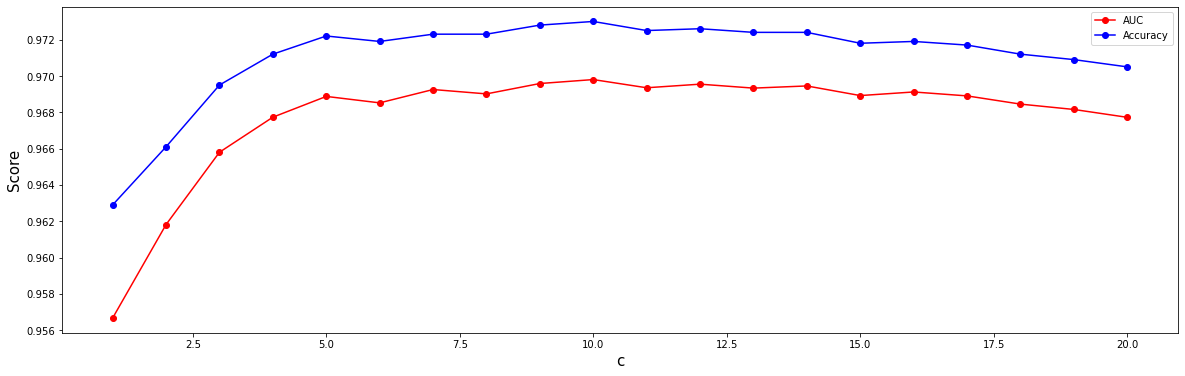

In [54]:
#identificando melhor parâmetro c para aplicar nos modelos

cv_svm = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) #validação cruzada

#fatiando ainda mais os dados, para viabilizar a simulação em várias execuções 
#estamos realizando em cima dos dados binários, pois tivemos muitos problemas/erros no cálculo das métricas
#para um problema de classificação multi-classe.
train_x = x_train_b[:10000]
train_y = y_train_b[:10000]

mauc_svm = []
macc_svm = []
vc = []

for c in range(1, 21):
    vauc_svm = []
    vacc_svm = []
    for train_index, test_index in cv_svm.split(train_x, train_y):
        x_train, x_test = x_train_b[train_index], x_train_b[test_index]
        y_train, y_test = y_train_b[train_index], y_train_b[test_index]
        model_svm = SVC(C = c, gamma = 'auto')
        model_svm.fit(x_train,y_train)
        y_pred_svm = model_svm.predict(x_test) 
        score = accuracy_score(y_pred_svm, y_test)
        vauc_svm.append(roc_auc_score(y_test, y_pred_svm))
        vacc_svm.append(accuracy_score(y_pred_svm, y_test))
    macc_svm.append(np.mean(vacc_svm))
    mauc_svm.append(np.mean(vauc_svm))
    vc.append(c)
    
#identificando o melhor parâmetro c, dada a acurácia e o AUC
best_c = np.argmax(mauc_svm)+1
print('Melhor c:', best_c, ' AUC:',mauc_svm[best_c-1])
plt.figure(figsize=(20,6))
plt.plot(vc, mauc_svm, '-ro', label= 'AUC')
plt.plot(vc, macc_svm, '-bo', label = 'Accuracy')
plt.xlabel('c', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

In [47]:
#SVM, realizando a modelagem com o melhor c com kernel linear para multiclasse com mapping number Over Sampling

model_SVMol = SVC(kernel='linear', C = best_c, random_state=1)
model_SVMol.fit(Xo,Yo)
y_pred_SVMol = model_SVMol.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_SVMol))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.11      0.93      0.19        72
           1       0.66      0.46      0.54      3689
           2       0.46      0.20      0.27      3205
           3       0.28      0.41      0.33      1739
           4       0.09      0.38      0.15       487
           5       0.55      0.58      0.56      2491
           6       0.60      0.46      0.52      2121
           7       0.39      0.65      0.49       566
           8       0.91      0.61      0.73       772
           9       0.30      0.68      0.41       172

    accuracy                           0.43     15314
   macro avg       0.43      0.54      0.42     15314
weighted avg       0.52      0.43      0.45     15314

+------------------------------------------------------------------+


In [48]:
#SVM, realizando a modelagem com o melhor c com kernel radial (rbf) para multiclasse com mapping number Over Sampling

model_SVMor = SVC(kernel='rbf', C = best_c, random_state=1)
model_SVMor.fit(Xo,Yo)
y_pred_SVMor = model_SVMor.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_SVMor))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.64      0.79      0.71        72
           1       0.92      0.89      0.90      3689
           2       0.84      0.83      0.84      3205
           3       0.80      0.84      0.82      1739
           4       0.59      0.81      0.68       487
           5       0.91      0.88      0.89      2491
           6       0.90      0.89      0.89      2121
           7       0.86      0.90      0.88       566
           8       0.96      0.93      0.95       772
           9       0.76      0.83      0.80       172

    accuracy                           0.87     15314
   macro avg       0.82      0.86      0.84     15314
weighted avg       0.87      0.87      0.87     15314

+------------------------------------------------------------------+


In [49]:
#SVM, realizando a modelagem com o melhor c com kernel linear para classificação binária

model_SVMolb = SVC(kernel='linear', C = best_c, random_state=1)
model_SVMolb.fit(x_train_b,y_train_b)
y_pred_SVMolb = model_SVMolb.predict(x_test_b)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_b, y_pred_SVMolb))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      9679
           1       0.91      0.93      0.92      5635

    accuracy                           0.94     15314
   macro avg       0.94      0.94      0.94     15314
weighted avg       0.94      0.94      0.94     15314

+------------------------------------------------------------------+


In [50]:
#SVM, realizando a modelagem com o melhor c com kernel radial (rbf) para classificação binária

model_SVMorb = SVC(kernel='rbf', C = best_c, random_state=1)
model_SVMorb.fit(x_train_b,y_train_b)
y_pred_SVMorb = model_SVMorb.predict(x_test_b)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_b, y_pred_SVMorb))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9679
           1       0.98      0.98      0.98      5635

    accuracy                           0.99     15314
   macro avg       0.99      0.99      0.99     15314
weighted avg       0.99      0.99      0.99     15314

+------------------------------------------------------------------+


### DT (DECISION TREE)

In [55]:
#arvore de decisão critério entropy para multiclasse com mapping number Over Sampling

model_DTCoe = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42)
model_DTCoe.fit(Xo,Yo)
y_pred_DTCoe = model_DTCoe.predict(x_test_map) 

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_DTCoe))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.20      0.68      0.31        72
           1       0.61      0.41      0.49      3689
           2       0.40      0.43      0.41      3205
           3       0.31      0.58      0.41      1739
           4       0.22      0.63      0.33       487
           5       0.62      0.59      0.60      2491
           6       0.46      0.29      0.36      2121
           7       0.27      0.28      0.27       566
           8       0.83      0.15      0.26       772
           9       0.09      0.04      0.06       172

    accuracy                           0.43     15314
   macro avg       0.40      0.41      0.35     15314
weighted avg       0.49      0.43      0.43     15314

+------------------------------------------------------------------+


In [56]:
#arvore de decisão critério gini para multiclasse com mapping number Over Sampling

model_DTCog = tree.DecisionTreeClassifier(criterion = 'gini', random_state=42)
model_DTCog.fit(Xo,Yo)
y_pred_DTCog = model_DTCog.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_DTCog))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.25      0.65      0.36        72
           1       0.86      0.53      0.66      3689
           2       0.49      0.40      0.44      3205
           3       0.34      0.59      0.43      1739
           4       0.21      0.73      0.32       487
           5       0.77      0.73      0.75      2491
           6       0.85      0.69      0.77      2121
           7       0.79      0.71      0.75       566
           8       0.98      0.85      0.91       772
           9       0.56      0.92      0.70       172

    accuracy                           0.60     15314
   macro avg       0.61      0.68      0.61     15314
weighted avg       0.68      0.60      0.62     15314

+------------------------------------------------------------------+


In [57]:
#arvore de decisão critério entropy para classificação binária

model_DTCbe = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42)
model_DTCbe.fit(x_train_b,y_train_b)
y_pred_DTCbe = model_DTCbe.predict(x_test_b) 

print('+------------------------------------------------------------------+')
print(classification_report(y_test_b, y_pred_DTCbe))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9679
           1       1.00      0.99      0.99      5635

    accuracy                           1.00     15314
   macro avg       1.00      1.00      1.00     15314
weighted avg       1.00      1.00      1.00     15314

+------------------------------------------------------------------+


In [58]:
#arvore de decisão critério gini para classificação binária

model_DTCbg = tree.DecisionTreeClassifier(criterion = 'gini', random_state=42)
model_DTCbg.fit(x_train_b,y_train_b)
y_pred_DTCbg = model_DTCbg.predict(x_test_b)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_b, y_pred_DTCbg))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9679
           1       0.99      0.99      0.99      5635

    accuracy                           1.00     15314
   macro avg       1.00      0.99      1.00     15314
weighted avg       1.00      1.00      1.00     15314

+------------------------------------------------------------------+


### NAIVE BAYES

In [59]:
#naive bayes para multiclasse com mapping number Over Sampling

model_NBCo = GaussianNB()
model_NBCo.fit(Xo,Yo)
y_pred_NBCo = model_NBCo.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_NBCo))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.51      0.46      0.48      3689
           2       0.41      0.33      0.37      3205
           3       0.27      0.18      0.21      1739
           4       0.08      0.49      0.14       487
           5       0.44      0.28      0.34      2491
           6       0.39      0.16      0.22      2121
           7       0.19      0.47      0.27       566
           8       0.46      0.35      0.40       772
           9       0.11      0.63      0.19       172

    accuracy                           0.33     15314
   macro avg       0.29      0.34      0.26     15314
weighted avg       0.40      0.33      0.34     15314

+------------------------------------------------------------------+


In [61]:
#naive bayes para classificação binária

model_NBCb = GaussianNB()
model_NBCb.fit(x_train_b,y_train_b)
y_pred_NBCb = model_NBCb.predict(x_test_b)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_b, y_pred_NBCb))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      9679
           1       0.75      0.59      0.66      5635

    accuracy                           0.78     15314
   macro avg       0.77      0.74      0.75     15314
weighted avg       0.77      0.78      0.77     15314

+------------------------------------------------------------------+


### ENSEMBLE STACKING PARTE I

In [63]:
#ensemble stacking para multiclasse com mapping number Over Sampling

lro = LogisticRegression()
model_Ensembleo = StackingClassifier(classifiers=[model_KNNo, model_SVMor, model_DTCog, model_NBCo], meta_classifier=lro)
model_Ensembleo.fit(Xo,Yo)
y_pred_Ensembleo = model_Ensembleo.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_Ensembleo))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.89      0.57      0.69      3689
           2       0.54      0.50      0.52      3205
           3       0.34      0.47      0.39      1739
           4       0.10      0.37      0.16       487
           5       0.64      0.70      0.67      2491
           6       0.83      0.54      0.66      2121
           7       0.47      0.72      0.57       566
           8       0.96      0.71      0.82       772
           9       0.45      0.85      0.59       172

    accuracy                           0.57     15314
   macro avg       0.52      0.54      0.51     15314
weighted avg       0.66      0.57      0.59     15314

+------------------------------------------------------------------+


In [67]:
#ensemble stacking para classificação binária

lrb = LogisticRegression()
model_Ensembleb = StackingClassifier(classifiers=[model_KNNb, model_SVMorb, model_DTCbg, model_NBCb], meta_classifier=lrb)
model_Ensembleb.fit(x_train_b,y_train_b)
y_pred_Ensembleb = model_Ensembleb.predict(x_test_b)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_b, y_pred_Ensembleb))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9679
           1       0.99      0.99      0.99      5635

    accuracy                           1.00     15314
   macro avg       1.00      0.99      1.00     15314
weighted avg       1.00      1.00      1.00     15314

+------------------------------------------------------------------+


## REDES NEURAIS

### PERCEPTRON

In [65]:
#perceptron para multiclasse com mapping number Over Sampling

cv = KFold(n_splits=10, shuffle=True, random_state=42)
model_PERCEPTRONo = Perceptron(random_state=0)
model_PERCEPTRONo.fit(Xo,Yo)
y_pred_PERCEPTRONo = model_PERCEPTRONo.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_PERCEPTRONo))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.06      0.71      0.12        72
           1       0.32      0.13      0.19      3689
           2       0.35      0.13      0.19      3205
           3       0.16      0.23      0.19      1739
           4       0.05      0.16      0.07       487
           5       0.20      0.19      0.19      2491
           6       0.26      0.30      0.28      2121
           7       0.14      0.46      0.21       566
           8       0.78      0.53      0.63       772
           9       0.10      0.34      0.15       172

    accuracy                           0.21     15314
   macro avg       0.24      0.32      0.22     15314
weighted avg       0.29      0.21      0.22     15314

+------------------------------------------------------------------+


In [66]:
#perceptron para classificação binária

cv = KFold(n_splits=10, shuffle=True, random_state=42)
model_PERCEPTRONo = Perceptron(random_state=0)
model_PERCEPTRONo.fit(x_train_b,y_train_b)
y_pred_PERCEPTRONo = model_PERCEPTRONo.predict(x_test_b)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_b, y_pred_PERCEPTRONo))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      9679
           1       0.74      0.89      0.81      5635

    accuracy                           0.84     15314
   macro avg       0.83      0.85      0.84     15314
weighted avg       0.86      0.84      0.84     15314

+------------------------------------------------------------------+


### MLP (MULTI-LAYER PERCEPTRON)

In [69]:
#multi-layer perceptron para multiclasse com mapping number Over Sampling

cv = KFold(n_splits=10, shuffle=True, random_state=42)
model_MLPo = MLPClassifier(max_iter=1000)
model_MLPo.fit(Xo,Yo)
y_pred_MLPo = model_MLPo.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_MLPo))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.64      0.85      0.73        72
           1       0.92      0.84      0.88      3689
           2       0.79      0.82      0.80      3205
           3       0.80      0.77      0.78      1739
           4       0.51      0.80      0.62       487
           5       0.86      0.89      0.87      2491
           6       0.88      0.81      0.85      2121
           7       0.86      0.91      0.88       566
           8       0.98      0.94      0.96       772
           9       0.81      0.93      0.87       172

    accuracy                           0.84     15314
   macro avg       0.80      0.86      0.82     15314
weighted avg       0.85      0.84      0.84     15314

+------------------------------------------------------------------+


In [70]:
#multi-layer perceptron para classificação binária

cv = KFold(n_splits=10, shuffle=True, random_state=42)
model_MLPb = MLPClassifier(max_iter=1000)
model_MLPb.fit(x_train_b,y_train_b)
y_pred_MLPb = model_MLPb.predict(x_test_b)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_b, y_pred_MLPb))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9679
           1       0.99      0.99      0.99      5635

    accuracy                           0.99     15314
   macro avg       0.99      0.99      0.99     15314
weighted avg       0.99      0.99      0.99     15314

+------------------------------------------------------------------+


### ENSEMBLE STACKING PARTE II

In [83]:
#Ensemble considerando os dois melhores modelos: SVM radial e MLP para multiclasse com Over Sampling

lrmso = LogisticRegression()
model_Ensemblemso = StackingClassifier(classifiers=[model_MLPo, model_SVMor], meta_classifier=lrmso)
model_Ensemblemso.fit(Xo,Yo)
y_pred_Ensemblemso = model_Ensemblemso.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_Ensemblemso))
print('+------------------------------------------------------------------+')

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.79      0.72      0.75        72
           1       0.89      0.87      0.88      3689
           2       0.81      0.80      0.81      3205
           3       0.80      0.84      0.82      1739
           4       0.59      0.81      0.68       487
           5       0.89      0.87      0.88      2491
           6       0.89      0.86      0.87      2121
           7       0.86      0.89      0.88       566
           8       0.96      0.96      0.96       772
           9       0.87      0.86      0.87       172

    accuracy                           0.85     15314
   macro avg       0.84      0.85      0.84     15314
weighted avg       0.86      0.85      0.85     15314

+------------------------------------------------------------------+


### AUTOENCODER

In [71]:
#autoencoder

def denoising_over_AE(input_shape):
    input = keras.layers.Input(shape=(input_shape))
    #encoder:
    encoder = keras.layers.BatchNormalization()(input)
    encoder = keras.layers.Dense(32, activation='relu')(encoder)
    encoder = keras.layers.Dense(32, activation='relu')(encoder)
    encoder = keras.layers.Dropout(0.2)(encoder)
    encoder = keras.layers.BatchNormalization()(encoder)
    encoder = keras.layers.Dense(14, activation='relu',name='code')(encoder)
    #decoder
    decoder = keras.layers.Dense(32,activation='relu',name='input_decoder')(encoder)
    decoder = keras.layers.Dense(32,activation='relu')(decoder)
    decoder = keras.layers.Dense(14,activation='tanh')(decoder)
    #autoencoder
    autoencoder = keras.models.Model(input, decoder)
    autoencoder.summary()
    return autoencoder

In [72]:
#instanciando o modelo para multiclasse com mapping number Over Sampling

modelo_Denoising_AEo = denoising_over_AE(14)

#sementes:
seed(1)
set_seed(2)

#taxa de aprendizado inicial de 0.003 e com decaimento a partir da época 5, exponencial a -0.2
lr = 0.003

def scheduler (epoch, lr):
    if epoch < 5:
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.2),4)

callbacklr = keras.callbacks.LearningRateScheduler(scheduler)

#Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto U
batch_size = 16
epochs = 20

modelo_Denoising_AEo.compile(loss='mse',
                 optimizer=keras.optimizers.Adam(lr=lr),
                 metrics=['accuracy'])

historyDenoisingo = modelo_Denoising_AEo.fit(x=Xo, y=Xo,
                                 epochs=epochs, 
                                 batch_size = batch_size,
                                 callbacks=[callbacklr],
                                 verbose=1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14)                56        
_________________________________________________________________
dense (Dense)                (None, 32)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 14)               

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.12      0.45      0.18     14800
           1       0.14      0.15      0.15     14800
           2       0.01      0.01      0.01     14800
           3       0.20      0.20      0.20     14800
           4       0.15      0.16      0.16     14800
           5       0.07      0.04      0.05     14800
           6       0.03      0.01      0.02     14800
           7       0.16      0.06      0.08     14800
           8       0.08      0.03      0.04     14800
           9       0.13      0.04      0.06     14800

    accuracy                           0.11    148000
   macro avg       0.11      0.11      0.09    148000
weighted avg       0.11      0.11      0.09    148000

+------------------------------------------------------------------+


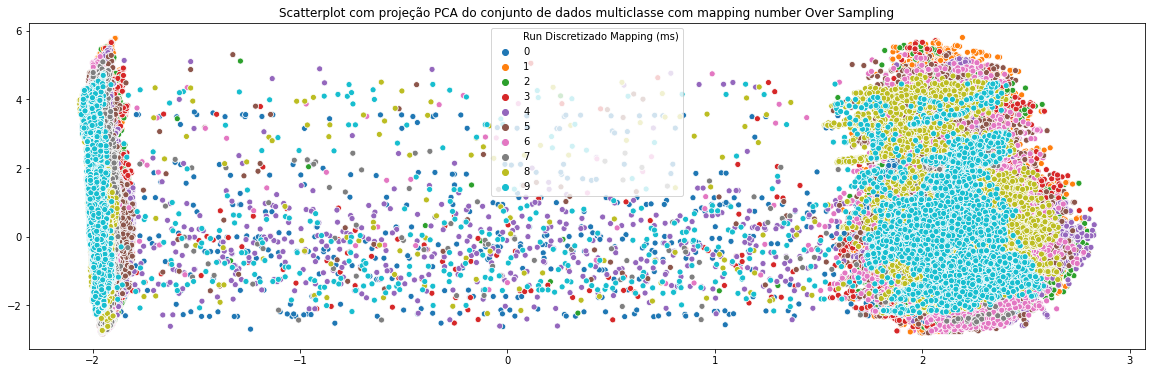

In [74]:
#extraindo a camada de código do modelo A para predição
extracto = keras.models.Model(modelo_Denoising_AEo.inputs, modelo_Denoising_AEo.layers[-4].output)
codeo = extracto.predict(Xo)

#realizando projeção PCA do conjunto S processado pelo encoder (camada de código) - reduzindo dimensão para 10 classes de saída
pca_S_Predo = PCA(n_components=10, random_state=1)
pca_S_Pred_resulto = pca_S_Predo.fit_transform(codeo)

#As funções argmax e argmin retornam, respectivamente, os índices do maior e do menor valor de um array. Uma ressalva é que, em caso de dois valores iguais serem os maiores (ou menores), elas retornam apenas o índice do primeiro.
#Usar numpy.argmax(a) retorna o índice do maior valor do array a como se o array estivesse na forma 1D, ou seja, do array.flatten().
#Se o array for 2D (uma matriz), é possível pegar o índice do maior valor de cada lista (ou seja, de cada linha) da matriz usando axis=1.
#Ou, com axis = 0, de cada coluna da matriz.

print('+------------------------------------------------------------------+')
print(classification_report(Yo, pca_S_Pred_resulto.argmax(axis=1)))
print('+------------------------------------------------------------------+')

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_S_Pred_resulto[:,0],y=pca_S_Pred_resulto[:,1],alpha='auto', hue=Yo, palette='tab10')
plt.title('Scatterplot com projeção PCA do conjunto de dados multiclasse com mapping number Over Sampling')
plt.show()

In [77]:
#instanciando o modelo para classificação binária

modelo_Denoising_AEb = denoising_over_AE(14)

#sementes:
seed(1)
set_seed(2)

#taxa de aprendizado inicial de 0.003 e com decaimento a partir da época 5, exponencial a -0.2
lr = 0.003

def scheduler (epoch, lr):
    if epoch < 5:
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.2),4)

callbacklr = keras.callbacks.LearningRateScheduler(scheduler)

#Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto U
batch_size = 16
epochs = 20

modelo_Denoising_AEb.compile(loss='mse',
                 optimizer=keras.optimizers.Adam(lr=lr),
                 metrics=['accuracy'])

historyDenoisingb = modelo_Denoising_AEb.fit(x=x_train_b, y=x_train_b,
                                 epochs=epochs, 
                                 batch_size = batch_size,
                                 callbacks=[callbacklr],
                                 verbose=1)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14)                56        
_________________________________________________________________
dense_8 (Dense)              (None, 32)                480       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 14)              

+------------------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.48      0.37      0.42     39083
           1       0.22      0.31      0.26     22172

    accuracy                           0.35     61255
   macro avg       0.35      0.34      0.34     61255
weighted avg       0.39      0.35      0.36     61255

+------------------------------------------------------------------+


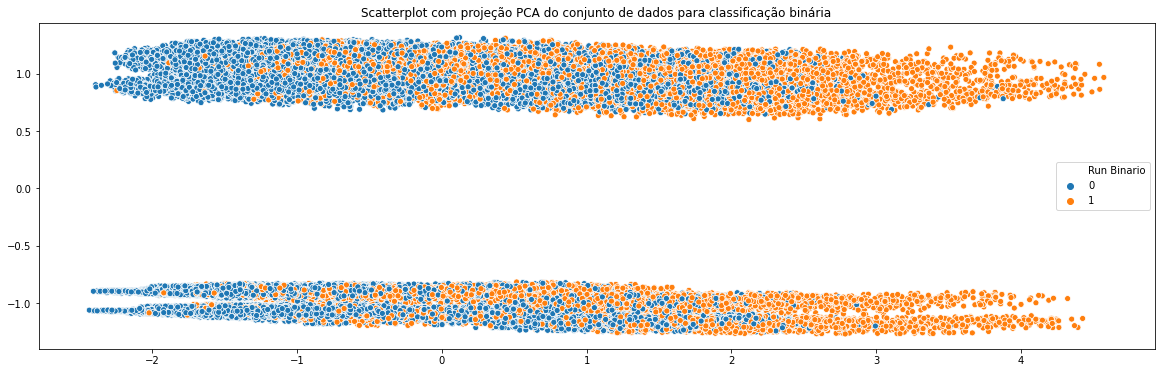

In [78]:
#extraindo a camada de código do modelo A para predição
extractb = keras.models.Model(modelo_Denoising_AEb.inputs, modelo_Denoising_AEb.layers[-4].output)
codeb = extractb.predict(x_train_b)

#realizando projeção PCA do conjunto S processado pelo encoder (camada de código) - reduzindo dimensão para 10 classes de saída
pca_S_Predb = PCA(n_components=2, random_state=1)
pca_S_Pred_resultb = pca_S_Predb.fit_transform(codeb)

#As funções argmax e argmin retornam, respectivamente, os índices do maior e do menor valor de um array. Uma ressalva é que, em caso de dois valores iguais serem os maiores (ou menores), elas retornam apenas o índice do primeiro.
#Usar numpy.argmax(a) retorna o índice do maior valor do array a como se o array estivesse na forma 1D, ou seja, do array.flatten().
#Se o array for 2D (uma matriz), é possível pegar o índice do maior valor de cada lista (ou seja, de cada linha) da matriz usando axis=1.
#Ou, com axis = 0, de cada coluna da matriz.

print('+------------------------------------------------------------------+')
print(classification_report(y_train_b, pca_S_Pred_resultb.argmax(axis=1)))
print('+------------------------------------------------------------------+')

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_S_Pred_resultb[:,0],y=pca_S_Pred_resultb[:,1],alpha='auto', hue=y_train_b, palette='tab10')
plt.title('Scatterplot com projeção PCA do conjunto de dados para classificação binária')
plt.show()

### REGRESSÃO LINEAR

Score R2: 0.5128393959543083


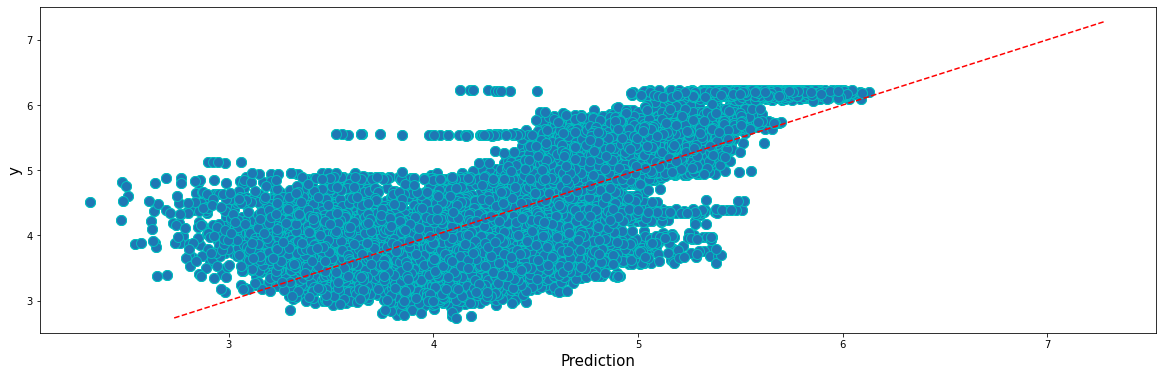

In [82]:
#regressão linear simples com dados reais tranformados em escala logarítimica

model_LR = LinearRegression(normalize=True)
model_LR.fit(x_train_log,y_train_log)
y_pred_LR = model_LR.predict(x_test_log)

score_LR = model_LR.score(x_train_log, y_train_log)
print('Score R2:',score_LR)

plt.figure(figsize=(20,6))

l = plt.plot(y_pred_LR, y_test_log, 'co')

plt.setp(l, markersize=10)
plt.setp(l, markerfacecolor='C0')

plt.ylabel("y", fontsize=15)
plt.xlabel("Prediction", fontsize=15)

l = plt.plot(y_pred_LR, y_test_log, 'co')
plt.setp(l, markersize=10)
plt.setp(l, markerfacecolor='C0')

plt.ylabel("y", fontsize=15)
plt.xlabel("Prediction", fontsize=15)

# mostra os valores preditos e originais
xl = np.arange(min(y_test_log), 1.2*max(y_test_log),(max(y_test_log)-min(y_test_log))/10)
yl = xl
plt.plot(xl, yl, 'r--')

plt.show(True)    